# Studying Neural Nets and Natural Language with TensorFlow - Wine_reviews DataSet

## Let's create a neural net to predict wine review evaluation points based upon their description!

### Data available at https://www.kaggle.com/datasets/zynicide/wine-reviews

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
# The main goal here is to learn and apply neural nets, so I will not be using every column

df = pd.read_csv('wine-reviews.csv', usecols= ['country', 'description', 'points', 'price', 
                                               'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=['description', 'points'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129908 non-null  object 
 1   description  129971 non-null  object 
 2   points       129971 non-null  int64  
 3   price        120975 non-null  float64
 4   variety      129970 non-null  object 
 5   winery       129971 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.9+ MB


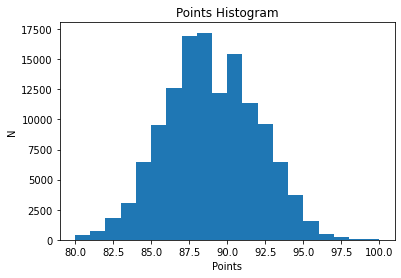

In [6]:
# Let's verify the target distribution

plt.hist(df.points, bins=20)
plt.title('Points Histogram')
plt.xlabel('Points')
plt.ylabel('N')
plt.show()

In [7]:
# Initially, to simplify the model, points will be separated as to classify the wines in two categories,
# 0 and 1:

df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'label']]

In [8]:
df

,description,label
0,"Aromas include tropical fruit, broom, brimston...",0
1,"This is ripe and fruity, a wine that is smooth...",0
2,"Tart and snappy, the flavors of lime flesh and...",0
3,"Pineapple rind, lemon pith and orange blossom ...",0
4,"Much like the regular bottling from 2012, this...",0
...,...,...
129966,Notes of honeysuckle and cantaloupe sweeten th...,1
129967,Citation is given as much as a decade of bottl...,1
129968,Well-drained gravel soil gives this wine its c...,1
129969,"A dry style of Pinot Gris, this is crisp with ...",1


In [16]:
# To assess overfitting, it is essential to have a validation subset, besides train and test.
# Splitting at 80% train, 10% test, 10% val

train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [17]:
# Defining function to get datasets from split dfs and building pipelines for the neural net training

def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df['description']
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [18]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

## To analyse written language, there are some options. First, let's use TensorFlow hub to access a NNLM database written langauge analysis and vector convertion and apply it to our wine reviews

In [24]:
hub_layer = hub.KerasLayer('nnlm-en-dim50_2', dtype=tf.string, trainable=True)

In [25]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4689755 , -0.1557115 , -0.14062823, ...,  0.02809818,
        -0.2350836 ,  0.02506753],
       [ 0.30171067,  0.00888665, -0.15886499, ..., -0.09628567,
         0.01191762, -0.24689035],
       [ 0.42685437,  0.02237918, -0.04397464, ..., -0.2017266 ,
        -0.19275774,  0.0509197 ],
       ...,
       [ 0.29242164, -0.3612303 ,  0.14579181, ..., -0.0670628 ,
         0.16453524, -0.07230484],
       [ 0.2753464 , -0.1885556 , -0.0103583 , ..., -0.10546747,
        -0.29747576,  0.0142909 ],
       [ 0.33945358, -0.23618123, -0.2305099 , ..., -0.08266268,
         0.27211103,  0.15572451]], dtype=float32)>

In [26]:
# Now, let's create the neural layers! Some dropouts are added to avoid overfit

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [28]:
# Time to train!!

history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 56s 536ms/step - loss: 0.6068 - accuracy: 0.6616 - val_loss: 0.4696 - val_accuracy: 0.7903
Epoch 2/5
102/102 [==============================] - 54s 528ms/step - loss: 0.4532 - accuracy: 0.7894 - val_loss: 0.3933 - val_accuracy: 0.8194
Epoch 3/5
102/102 [==============================] - 52s 510ms/step - loss: 0.3938 - accuracy: 0.8268 - val_loss: 0.3752 - val_accuracy: 0.8269
Epoch 4/5
102/102 [==============================] - 53s 518ms/step - loss: 0.3627 - accuracy: 0.8450 - val_loss: 0.3693 - val_accuracy: 0.8326
Epoch 5/5
102/102 [==============================] - 54s 532ms/step - loss: 0.3390 - accuracy: 0.8578 - val_loss: 0.3716 - val_accuracy: 0.8325


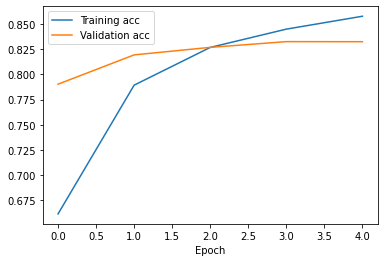

In [29]:
# Training seems to be successful! Let's plot the accuracies to better visualize

plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.xlabel('Epoch')
plt.legend()

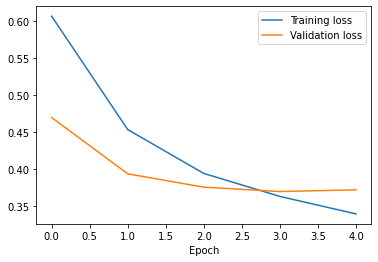

In [30]:
# They seem to behave properly. Losses now

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()

In [31]:
# Finally, evaluating the model!

# Nice results, accuracy over 80%!!!

model.evaluate(test_data)

13/13 [==============================] - 1s 64ms/step - loss: 0.3705 - accuracy: 0.8320


[0.3705463707447052, 0.8319741487503052]

## As expressed before, using a language interpreter database is an option. Another one is to build one with Keras! 

In [32]:
# Let's use all our vocabulary to encode the words in the descriptions

encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [33]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [34]:
# Creating layers. A Long-Short-Term Memory layer is added to help with back-propagation, since the neural
# net is using vectorized text as input.

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
# Metrics

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [37]:
# Training!!

## Isn't it beautiful to watch the computer 'learning'??

history = model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
102/102 [==============================] - 46s 400ms/step - loss: 0.5467 - accuracy: 0.7094 - val_loss: 0.3940 - val_accuracy: 0.8188
Epoch 2/5
102/102 [==============================] - 48s 471ms/step - loss: 0.3678 - accuracy: 0.8340 - val_loss: 0.3550 - val_accuracy: 0.8407
Epoch 3/5
102/102 [==============================] - 43s 421ms/step - loss: 0.3488 - accuracy: 0.8439 - val_loss: 0.3455 - val_accuracy: 0.8449
Epoch 4/5
102/102 [==============================] - 42s 410ms/step - loss: 0.3445 - accuracy: 0.8451 - val_loss: 0.3485 - val_accuracy: 0.8435
Epoch 5/5
102/102 [==============================] - 43s 424ms/step - loss: 0.3387 - accuracy: 0.8486 - val_loss: 0.3546 - val_accuracy: 0.8409


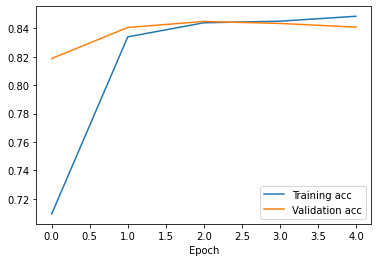

In [38]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.xlabel('Epoch')
plt.legend()

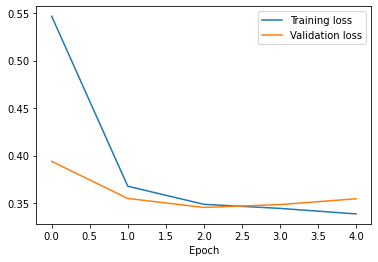

In [39]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.legend()

In [40]:
model.evaluate(test_data)

13/13 [==============================] - 2s 161ms/step - loss: 0.3580 - accuracy: 0.8393


[0.35801827907562256, 0.8392829895019531]

In [ ]:
# Slightly better, practically equivalent accuracy!!